# <center> Stock Prediction Based on Twitter Sentiment Analysis —— Take United Airlines as Example
## <center> *Designed by Zhu Lei*

#### Importing machine learning libraries

In [2]:
import numpy as np
import pandas as pd
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
import matplotlib.pyplot as mlpt

#### Importing library to fetch data from twitter

In [3]:
import tweepy
import csv
import pandas as pd
import random
import numpy as np
import pandas as pd

#### Setting up consumer key and access token which obtained from Twitter Developer(https://developer.twitter.com/en)

In [62]:
consumer_key    = '3jmA1BqasLHfItBXj3KnAIGFB'
consumer_secret = 'imyEeVTctFZuK62QHmL1I0AUAMudg5HKJDfkx0oR7oFbFinbvA'

access_token  = '265857263-pF1DRxgIcxUbxEEFtLwLODPzD3aMl6d4zOKlMnme'
access_token_secret = 'uUFoOOGeNJfOYD3atlcmPtaxxniXxQzAU4ESJLopA1lbC'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

#### Fetching tweets for United Airlines in extended mode (means entire tweet will come and not just few words + link)

In [63]:
fetch_tweets=tweepy.Cursor(api.search_tweets, q="#unitedAIRLINES",count=100, lang ="en",since="2022-7-01", tweet_mode="extended").items()
data=pd.DataFrame(data=[[tweet_info.created_at.date(),tweet_info.full_text]for tweet_info in fetch_tweets],columns=['Date','Tweets'])

Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since
Unexpected parameter: since


In [64]:
data

,Date,Tweets
0,2022-07-30,"United Airlines: ""Take Me Along"" (Michael Cimi..."
1,2022-07-30,@rolandsmartin @united @BlkStarNetwork This is...
2,2022-07-30,My bag was 2 pounds overweight and #UnitedAirl...
3,2022-07-30,ICAO: A8CFFD\nFlt: UAL940 #UnitedAirlines #EWR...
4,2022-07-30,#unitedairlines fucking sucks
...,...,...
512,2022-07-20,A slew of #earnings is expected to keep #inves...
513,2022-07-20,@united Is this true or false ? https://t.co/D...
514,2022-07-20,RT @wildlyartistic: @united you expect passeng...
515,2022-07-20,ICAO: A8CFFD\nFlt: UAL272 #UnitedAirlines #EWR...


#### Removing special character from each tweets

In [65]:
data.to_csv("Tweets.csv")
cdata=pd.DataFrame(columns=['Date','Tweets'])
total=100
index=0
for index,row in data.iterrows():
    stre=row["Tweets"]
    my_new_string = re.sub('[^ a-zA-Z0-9]', '', stre)
    temp_df = pd.DataFrame([[data["Date"].iloc[index], 
                            my_new_string]], columns = ['Date','Tweets'])
    cdata = pd.concat([cdata, temp_df], axis = 0).reset_index(drop = True)
    # index=index+1
#print(cdata.dtypes)

#### Displaying the data with date and tweets and what will be notice is that there are multiple tweets for each day. So we will club them together later.

In [66]:
cdata

,Date,Tweets
0,2022-07-30,United Airlines Take Me Along Michael Cimino 1...
1,2022-07-30,rolandsmartin united BlkStarNetwork This is ri...
2,2022-07-30,My bag was 2 pounds overweight and UnitedAirli...
3,2022-07-30,ICAO A8CFFDFlt UAL940 UnitedAirlines EWRLHRFir...
4,2022-07-30,unitedairlines fucking sucks
...,...,...
512,2022-07-20,A slew of earnings is expected to keep investo...
513,2022-07-20,united Is this true or false httpstcoDvPrrKiT...
514,2022-07-20,RT wildlyartistic united you expect passengers...
515,2022-07-20,ICAO A8CFFDFlt UAL272 UnitedAirlines EWRNCEFir...


#### Creating a dataframe where we will combine the tweets date wise and store into "ccdata"

In [67]:
ccdata=pd.DataFrame(columns=['Date','Tweets'])

In [68]:
indx=0
get_tweet=""
for i in range(0,len(cdata)-1):
    get_date=cdata.Date.iloc[i]
    next_date=cdata.Date.iloc[i+1]
    if(str(get_date)==str(next_date)):
        get_tweet=get_tweet+cdata.Tweets.iloc[i]+" "
    if(str(get_date)!=str(next_date)):
        temp_df = pd.DataFrame([[get_date, 
                                get_tweet]], columns = ['Date','Tweets'])
        ccdata = pd.concat([ccdata, temp_df], axis = 0).reset_index(drop = True)
        get_tweet=" "

#### All the tweets has been clubbed as per their date.
#### And we can take a look.

In [69]:
ccdata

,Date,Tweets
0,2022-07-30,United Airlines Take Me Along Michael Cimino 1...
1,2022-07-29,Delayed flight from BTR got me to my gate in ...
2,2022-07-28,Hello united Im one of your pilot Need your s...
3,2022-07-27,united UA1431 from LAX to HNL delayed again t...
4,2022-07-26,RT diecastryan SFO terminal G at sunset sfo s...
5,2022-07-25,RT diecastryan SFO terminal G at sunset sfo s...
6,2022-07-24,RT USASWW1 JudahBDavis amtrackmacon3 templefu...
7,2022-07-23,United Airlines to Axe 50 Daily Flights at Ne...
8,2022-07-22,UnitedAirlines on a flight from AZ to EWR and...
9,2022-07-21,Had united told be before I got on their plan...


#### Now to know the "closing price" of each day we will import STOCK PRICE DATA for UNITED AIRLINES from "yahoo.finance"(https://finance.yahoo.com/quote/UAL/history?period1=1625097600&period2=1659139200&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true). We will consider "Close" price only.

In [70]:
read_stock_p = pd.read_csv('UAL.csv')
read_stock_p

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-07-01,52.790001,53.759998,52.689999,53.080002,53.080002,8577600
1,2021-07-02,53.169998,53.169998,52.090000,52.770000,52.770000,9205500
2,2021-07-06,52.680000,53.209999,51.020000,51.439999,51.439999,10652300
3,2021-07-07,51.040001,51.869999,49.779999,50.299999,50.299999,12719100
4,2021-07-08,49.080002,50.520000,48.570000,49.660000,49.660000,13207800
...,...,...,...,...,...,...,...
266,2022-07-22,37.799999,38.250000,36.020000,36.330002,36.330002,14562900
267,2022-07-25,36.029999,36.410000,35.189999,36.340000,36.340000,10186900
268,2022-07-26,35.759998,36.139999,35.279999,35.340000,35.340000,8151700
269,2022-07-27,36.180000,36.740002,35.290001,36.419998,36.419998,10580700


#### Adding a "Price" column in our dataframe and fetching the stock price as per the date in our dataframe.

In [71]:
ccdata['Prices']=""

In [72]:
indx=0
for i in range (0,len(ccdata)):
    for j in range (0,len(read_stock_p)):
        get_tweet_date=ccdata.Date.iloc[i]
        get_stock_date=read_stock_p.Date.iloc[j]
        if(str(get_stock_date)==str(get_tweet_date)):
            #print(get_stock_date," ",get_tweet_date)
            # ccdata.set_value(i,'Prices',int(read_stock_p.Close[j]))
            ccdata['Prices'].iloc[i] = int(read_stock_p.Close[j])

#### Prices are fetched but some entires are blank as close price might not be available for that day due to some reason (like holiday, etc.)

In [73]:
ccdata

,Date,Tweets,Prices
0,2022-07-30,United Airlines Take Me Along Michael Cimino 1...,
1,2022-07-29,Delayed flight from BTR got me to my gate in ...,
2,2022-07-28,Hello united Im one of your pilot Need your s...,36
3,2022-07-27,united UA1431 from LAX to HNL delayed again t...,36
4,2022-07-26,RT diecastryan SFO terminal G at sunset sfo s...,35
5,2022-07-25,RT diecastryan SFO terminal G at sunset sfo s...,36
6,2022-07-24,RT USASWW1 JudahBDavis amtrackmacon3 templefu...,
7,2022-07-23,United Airlines to Axe 50 Daily Flights at Ne...,
8,2022-07-22,UnitedAirlines on a flight from AZ to EWR and...,36
9,2022-07-21,Had united told be before I got on their plan...,37


#### So we take the mean for the close price and put it in the blank value

In [74]:
mean=0
summ=0
count=0
for i in range(0,len(ccdata)):
    if(ccdata.Prices.iloc[i]!=""):
        summ=summ+int(ccdata.Prices.iloc[i])
        count=count+1
mean=summ/count
for i in range(0,len(ccdata)):
    if(ccdata.Prices.iloc[i]==""):
        ccdata.Prices.iloc[i]=int(mean)

#### Now all the entries have some value

In [75]:
ccdata

,Date,Tweets,Prices
0,2022-07-30,United Airlines Take Me Along Michael Cimino 1...,36
1,2022-07-29,Delayed flight from BTR got me to my gate in ...,36
2,2022-07-28,Hello united Im one of your pilot Need your s...,36
3,2022-07-27,united UA1431 from LAX to HNL delayed again t...,36
4,2022-07-26,RT diecastryan SFO terminal G at sunset sfo s...,35
5,2022-07-25,RT diecastryan SFO terminal G at sunset sfo s...,36
6,2022-07-24,RT USASWW1 JudahBDavis amtrackmacon3 templefu...,36
7,2022-07-23,United Airlines to Axe 50 Daily Flights at Ne...,36
8,2022-07-22,UnitedAirlines on a flight from AZ to EWR and...,36
9,2022-07-21,Had united told be before I got on their plan...,37


#### Making "prices" column as integer so mathematical operations could be performed easily.

In [76]:
ccdata['Prices'] = ccdata['Prices'].apply(np.int64)

#### Adding 4 new columns in our dataframe so that sentiment analysis could be performed.. Comp is "Compound" it will tell whether the statement is overall negative or positive. If it has negative value then it is negative, if it has positive value then it is positive. If it has value 0, then it is neutral.

In [77]:
ccdata["Comp"] = ''
ccdata["Negative"] = ''
ccdata["Neutral"] = ''
ccdata["Positive"] = ''
ccdata

,Date,Tweets,Prices,Comp,Negative,Neutral,Positive
0,2022-07-30,United Airlines Take Me Along Michael Cimino 1...,36,,,,
1,2022-07-29,Delayed flight from BTR got me to my gate in ...,36,,,,
2,2022-07-28,Hello united Im one of your pilot Need your s...,36,,,,
3,2022-07-27,united UA1431 from LAX to HNL delayed again t...,36,,,,
4,2022-07-26,RT diecastryan SFO terminal G at sunset sfo s...,35,,,,
5,2022-07-25,RT diecastryan SFO terminal G at sunset sfo s...,36,,,,
6,2022-07-24,RT USASWW1 JudahBDavis amtrackmacon3 templefu...,36,,,,
7,2022-07-23,United Airlines to Axe 50 Daily Flights at Ne...,36,,,,
8,2022-07-22,UnitedAirlines on a flight from AZ to EWR and...,36,,,,
9,2022-07-21,Had united told be before I got on their plan...,37,,,,


#### Downloading this package was essential to perform sentiment analysis.

In [78]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhouxingwei/opt/miniconda3/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

#### This part of the code is responsible for assigning the polarity for each statement. That is how much positive, negative, neutral you statement is. And also assign the compound value that is overall sentiment of the statement.

In [79]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
sentiment_i_a = SentimentIntensityAnalyzer()
for indexx, row in ccdata.T.iteritems():
    try:
        sentence_i = unicodedata.normalize('NFKD', ccdata.loc[indexx, 'Tweets'])
        sentence_sentiment = sentiment_i_a.polarity_scores(sentence_i)
        ccdata['Comp'].iloc[indexx] = sentence_sentiment['compound']
        ccdata['Negative'].iloc[indexx] = sentence_sentiment['neg']
        ccdata['Neutral'].iloc[indexx] = sentence_sentiment['neu']
        ccdata['Positive'].iloc[indexx] = sentence_sentiment['compound']
        # ccdata.set_value(indexx, 'Comp', sentence_sentiment['pos'])
        # ccdata.set_value(indexx, 'Negative', sentence_sentiment['neg'])
        # ccdata.set_value(indexx, 'Neutral', sentence_sentiment['neu'])
        # ccdata.set_value(indexx, 'Positive', sentence_sentiment['pos'])
    except TypeError:
        print (ccdata.loc[indexx, 'Tweets'])
        print (indexx)

/var/folders/6h/0cw63sbs0cl_9hz8mj2d3jl40000gn/T/ipykernel_41862/4058129665.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccdata['Comp'].iloc[indexx] = sentence_sentiment['compound']
/var/folders/6h/0cw63sbs0cl_9hz8mj2d3jl40000gn/T/ipykernel_41862/4058129665.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccdata['Negative'].iloc[indexx] = sentence_sentiment['neg']
/var/folders/6h/0cw63sbs0cl_9hz8mj2d3jl40000gn/T/ipykernel_41862/4058129665.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [80]:
ccdata

,Date,Tweets,Prices,Comp,Negative,Neutral,Positive
0,2022-07-30,United Airlines Take Me Along Michael Cimino 1...,36,-0.2776,0.098,0.8,-0.2776
1,2022-07-29,Delayed flight from BTR got me to my gate in ...,36,0.9999,0.029,0.722,0.9999
2,2022-07-28,Hello united Im one of your pilot Need your s...,36,0.9987,0.021,0.829,0.9987
3,2022-07-27,united UA1431 from LAX to HNL delayed again t...,36,0.9988,0.089,0.741,0.9988
4,2022-07-26,RT diecastryan SFO terminal G at sunset sfo s...,35,0.9998,0.038,0.741,0.9998
5,2022-07-25,RT diecastryan SFO terminal G at sunset sfo s...,36,0.9923,0.055,0.853,0.9923
6,2022-07-24,RT USASWW1 JudahBDavis amtrackmacon3 templefu...,36,0.9992,0.082,0.74,0.9992
7,2022-07-23,United Airlines to Axe 50 Daily Flights at Ne...,36,0.9992,0.083,0.746,0.9992
8,2022-07-22,UnitedAirlines on a flight from AZ to EWR and...,36,0.9381,0.08,0.827,0.9381
9,2022-07-21,Had united told be before I got on their plan...,37,0.9959,0.04,0.836,0.9959


#### Calculating the percentage of postive and negative tweets, and plotting the PIE chart for the same.

% of positive tweets=  90.0
% of negative tweets=  10.0


[]

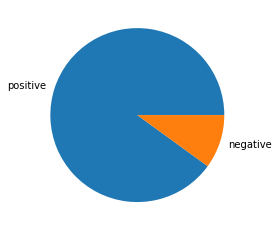

In [81]:
posi=0
nega=0
for i in range (0,len(ccdata)):
    get_val=ccdata.Comp[i]
    if(float(get_val)<(0)):
        nega=nega+1
    if(float(get_val>(0))):
        posi=posi+1
posper=(posi/(len(ccdata)))*100
negper=(nega/(len(ccdata)))*100
print("% of positive tweets= ",posper)
print("% of negative tweets= ",negper)
arr=np.asarray([posper,negper], dtype=int)
mlpt.pie(arr,labels=['positive','negative'])
mlpt.plot()

#### Making a new dataframe with necessary columns for providing machine learning.

In [82]:
df_=ccdata[['Date','Prices','Comp','Negative','Neutral','Positive']].copy()

In [83]:
df_

,Date,Prices,Comp,Negative,Neutral,Positive
0,2022-07-30,36,-0.2776,0.098,0.8,-0.2776
1,2022-07-29,36,0.9999,0.029,0.722,0.9999
2,2022-07-28,36,0.9987,0.021,0.829,0.9987
3,2022-07-27,36,0.9988,0.089,0.741,0.9988
4,2022-07-26,35,0.9998,0.038,0.741,0.9998
5,2022-07-25,36,0.9923,0.055,0.853,0.9923
6,2022-07-24,36,0.9992,0.082,0.74,0.9992
7,2022-07-23,36,0.9992,0.083,0.746,0.9992
8,2022-07-22,36,0.9381,0.08,0.827,0.9381
9,2022-07-21,37,0.9959,0.04,0.836,0.9959


#### Dividing the dataset into train and test.

In [84]:
train_start_index = '0'
train_end_index = '7'
test_start_index = '8'
test_end_index = '9'
train = df_.loc[train_start_index : train_end_index,:]
test = df_.loc[test_start_index:test_end_index,:]

#### Making a 2D array that will store the Negative and Positive sentiment for Training dataset.

In [85]:
sentiment_score_list = []
for date, row in train.T.iteritems():
    sentiment_score = np.asarray([df_.loc[date, 'Negative'],df_.loc[date, 'Positive']])
    sentiment_score_list.append(sentiment_score)
numpy_df_train = np.asarray(sentiment_score_list)

In [86]:
print(numpy_df_train)

[[ 0.098  -0.2776]
 [ 0.029   0.9999]
 [ 0.021   0.9987]
 [ 0.089   0.9988]
 [ 0.038   0.9998]
 [ 0.055   0.9923]
 [ 0.082   0.9992]
 [ 0.083   0.9992]]


#### Making a 2D array that will store the Negative and Positive sentiment for Testing dataset.

In [87]:
sentiment_score_list = []
for date, row in test.T.iteritems():
    sentiment_score = np.asarray([df_.loc[date, 'Negative'],df_.loc[date, 'Positive']])
    sentiment_score_list.append(sentiment_score)
numpy_df_test = np.asarray(sentiment_score_list)

In [88]:
print(numpy_df_test)

[[0.08   0.9381]
 [0.04   0.9959]]


#### Making 2 dataframe for Training and Testing "Prices". You can also make 1-D array for the same.

In [89]:
y_train = pd.DataFrame(train['Prices'])
#y_train=[91,91,91,92,91,92,91]
y_test = pd.DataFrame(test['Prices'])
print(y_train)

   Prices
0      36
1      36
2      36
3      36
4      35
5      36
6      36
7      36


#### Fitting the sentiments(this acts as in independent value) and prices(this acts as a dependent value (like class-lables in iris dataset))

In [90]:
# from treeinterpreter import treeinterpreter as ti
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report,confusion_matrix

rf = RandomForestRegressor()
rf.fit(numpy_df_train, y_train)

/var/folders/6h/0cw63sbs0cl_9hz8mj2d3jl40000gn/T/ipykernel_41862/1504975680.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(numpy_df_train, y_train)


RandomForestRegressor()

#### Making Predictions

In [91]:
prediction = rf.predict(numpy_df_test)

In [92]:
print(prediction)

[36.   35.85]


#### Importing matplotlib library for plotting graph

In [93]:
import matplotlib.pyplot as plt

#### Defining index position for the test data. Making dataframe for the predicted value.

In [94]:
idx=np.arange(int(test_start_index),int(test_end_index)+1)
predictions_df_ = pd.DataFrame(data=prediction[0:], index = idx, columns=['Prices'])

In [95]:
predictions_df_

,Prices
8,36.00
9,35.85


#### Plotting the graph for the Predicted_price VS Actual Price

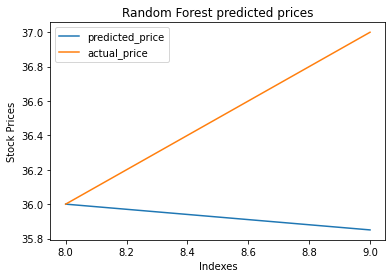

In [97]:
ax = predictions_df_.rename(columns={"Prices": "predicted_price"}).plot(title='Random Forest predicted prices')#predicted value
ax.set_xlabel("Indexes")
ax.set_ylabel("Stock Prices")
fig = y_test.rename(columns={"Prices": "actual_price"}).plot(ax = ax).get_figure()#actual value

#### As the plot above shows, the prediction does not work well. 

In [98]:
# from treeinterpreter import treeinterpreter as ti
# from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report,confusion_matrix

reg = LinearRegression()
reg.fit(numpy_df_train, y_train)

LinearRegression()

In [99]:
reg.predict(numpy_df_test)

array([[35.94729318],
       [35.79152843]])

#### Since our dataset is very small and as you can see that fetching 600 tweets could only make data for just 10 days.Also the prediction is not very great in such small dataset. So we found this new dataset on internet which has the Text as "Tweets" and respective "close price" and "Adjusted close price".


#### Adjusted Close Price: An adjusted closing price is a stock's closing price on any given day of trading that has been amended to include any distributions and corporate actions that occurred at any time before the next day's open.

In [4]:
stocks_dataf = pd.read_pickle('Twitter_Dataset.pkl')
stocks_dataf.columns=['closing_price','adj_close_price','Tweets']

## New dataset

In [5]:
stocks_dataf

,closing_price,adj_close_price,Tweets
2007-01-01,12469.971875,12469.971875,. What Sticks from '06. Somalia Orders Islamis...
2007-01-02,12472.245703,12472.245703,. Heart Health: Vitamin Does Not Prevent Death...
2007-01-03,12474.519531,12474.519531,. Google Answer to Filling Jobs Is an Algorith...
2007-01-04,12480.690430,12480.690430,. Helping Make the Shift From Combat to Commer...
2007-01-05,12398.009766,12398.009766,. Rise in Ethanol Raises Concerns About Corn a...
...,...,...,...
2016-12-27,19945.039062,19945.039062,. Should the U.S. Embassy Be Moved From Tel Av...
2016-12-28,19833.679688,19833.679688,. When Finding the Right Lawyer Seems Daunting...
2016-12-29,19819.779297,19819.779297,. Does Empathy Guide or Hinder Moral Action?. ...
2016-12-30,19762.599609,19762.599609,. Shielding Seized Assets From Corruption’s Cl...


#### Removing dot (.) and space from the Tweets

In [7]:
stocks_dataf['adj_close_price'] = stocks_dataf['adj_close_price'].apply(np.int64)
stocks_dataf = stocks_dataf[['Date','adj_close_price', 'Tweets']]
stocks_dataf['Tweets'] = stocks_dataf['Tweets'].map(lambda x: x.lstrip('.-'))
stocks_dataf

,Date,adj_close_price,Tweets
0,2007-01-01,12469,What Sticks from '06. Somalia Orders Islamist...
1,2007-01-02,12472,Heart Health: Vitamin Does Not Prevent Death ...
2,2007-01-03,12474,Google Answer to Filling Jobs Is an Algorithm...
3,2007-01-04,12480,Helping Make the Shift From Combat to Commerc...
4,2007-01-05,12398,Rise in Ethanol Raises Concerns About Corn as...
...,...,...,...
3648,2016-12-27,19945,Should the U.S. Embassy Be Moved From Tel Avi...
3649,2016-12-28,19833,"When Finding the Right Lawyer Seems Daunting,..."
3650,2016-12-29,19819,Does Empathy Guide or Hinder Moral Action?. C...
3651,2016-12-30,19762,Shielding Seized Assets From Corruption’s Clu...


#### Making new dataframe and only considering "Adjusted close price". And date as index vlaue.

In [8]:
dataframe = stocks_dataf[['adj_close_price']].copy()
dataframe

,adj_close_price
0,12469
1,12472
2,12474
3,12480
4,12398
...,...
3648,19945
3649,19833
3650,19819
3651,19762


In [9]:
dataframe["Comp"] = ''
dataframe["Negative"] = ''
dataframe["Neutral"] = ''
dataframe["Positive"] = ''

In [10]:
dataframe

,adj_close_price,Comp,Negative,Neutral,Positive
0,12469,,,,
1,12472,,,,
2,12474,,,,
3,12480,,,,
4,12398,,,,
...,...,...,...,...,...
3648,19945,,,,
3649,19833,,,,
3650,19819,,,,
3651,19762,,,,


In [12]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhouxingwei/opt/miniconda3/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [13]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
sentiment_i_a = SentimentIntensityAnalyzer()
for indexx, row in dataframe.T.iteritems():
    try:
        sentence_i = unicodedata.normalize('NFKD', stocks_dataf.loc[indexx, 'Tweets'])
        sentence_sentiment = sentiment_i_a.polarity_scores(sentence_i)
        dataframe['Comp'].iloc[indexx] = sentence_sentiment['compound']
        dataframe['Negative'].iloc[indexx] = sentence_sentiment['neg']
        dataframe['Neutral'].iloc[indexx] = sentence_sentiment['neu']
        dataframe['Positive'].iloc[indexx] = sentence_sentiment['compound']
        '''dataframe.set_index(indexx, 'Comp', sentence_sentiment['compound'])
        dataframe.set_index(indexx, 'Negative', sentence_sentiment['neg'])
        dataframe.set_index(indexx, 'Neutral', sentence_sentiment['neu'])
        dataframe.set_index(indexx, 'Positive', sentence_sentiment['pos'])'''
    except TypeError:
        print (stocks_dataf.loc[indexx, 'Tweets'])
        print (indexx)

/var/folders/6h/0cw63sbs0cl_9hz8mj2d3jl40000gn/T/ipykernel_43531/269771145.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Comp'].iloc[indexx] = sentence_sentiment['compound']
/var/folders/6h/0cw63sbs0cl_9hz8mj2d3jl40000gn/T/ipykernel_43531/269771145.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Negative'].iloc[indexx] = sentence_sentiment['neg']
/var/folders/6h/0cw63sbs0cl_9hz8mj2d3jl40000gn/T/ipykernel_43531/269771145.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [14]:
dataframe

,adj_close_price,Comp,Negative,Neutral,Positive
0,12469,-0.9814,0.159,0.749,-0.9814
1,12472,-0.8521,0.116,0.785,-0.8521
2,12474,-0.9993,0.198,0.737,-0.9993
3,12480,-0.9982,0.131,0.806,-0.9982
4,12398,-0.9901,0.124,0.794,-0.9901
...,...,...,...,...,...
3648,19945,-0.9898,0.178,0.719,-0.9898
3649,19833,-0.9844,0.177,0.704,-0.9844
3650,19819,-0.9782,0.14,0.761,-0.9782
3651,19762,-0.995,0.168,0.734,-0.995


Percentage of positive tweets is  44.34711196277033
Percentage of negative tweets is  55.43388995346291


[]

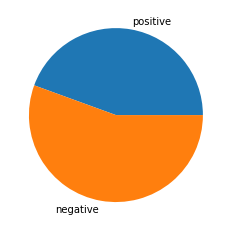

In [17]:
posi=0
nega=0
for i in range (0,len(dataframe)):
    get_val=dataframe.Comp[i]
    if(float(get_val)<(-0.99)):
        nega=nega+1
    if(float(get_val>(-0.99))):
        posi=posi+1
posper=(posi/(len(dataframe)))*100
negper=(nega/(len(dataframe)))*100
print("Percentage of positive tweets is ",posper)
print("Percentage of negative tweets is ",negper)
arr=np.asarray([posper,negper], dtype=int)
mlpt.pie(arr,labels=['positive','negative'])
mlpt.plot()

In [127]:
dataframe.index = stocks_dataf['Date']
dataframe

,adj_close_price,Comp,Negative,Neutral,Positive
Date,,,,,
2007-01-01,12469,-0.9814,0.159,0.749,-0.9814
2007-01-02,12472,-0.8521,0.116,0.785,-0.8521
2007-01-03,12474,-0.9993,0.198,0.737,-0.9993
2007-01-04,12480,-0.9982,0.131,0.806,-0.9982
2007-01-05,12398,-0.9901,0.124,0.794,-0.9901
...,...,...,...,...,...
2016-12-27,19945,-0.9898,0.178,0.719,-0.9898
2016-12-28,19833,-0.9844,0.177,0.704,-0.9844
2016-12-29,19819,-0.9782,0.14,0.761,-0.9782


#### Set the training data set and test data set according to the date.

In [128]:
train_data_start = '2007-01-01'
train_data_end = '2014-12-31'
test_data_start = '2015-01-01'
test_data_end = '2016-12-31'
train = dataframe.loc[train_data_start : train_data_end]
test = dataframe.loc[test_data_start:test_data_end]

In [129]:
list_of_sentiments_score = []
for date, row in train.T.iteritems():
    sentiment_score = np.asarray([dataframe.loc[date, 'Comp']])
    list_of_sentiments_score.append(sentiment_score)
numpy_dataframe_train = np.asarray(list_of_sentiments_score)

In [130]:
list_of_sentiments_score = []
for date, row in test.T.iteritems():
    sentiment_score = np.asarray([dataframe.loc[date, 'Comp']])
    list_of_sentiments_score.append(sentiment_score)
numpy_dataframe_test = np.asarray(list_of_sentiments_score)

In [131]:
y_train = pd.DataFrame(train['adj_close_price'])
y_test = pd.DataFrame(test['adj_close_price'])

In [132]:
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score

0.29341364509830814


/var/folders/6h/0cw63sbs0cl_9hz8mj2d3jl40000gn/T/ipykernel_41862/1569841466.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['adj_close_price']=test['adj_close_price'].apply(np.int64)


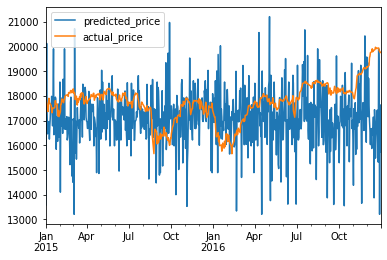

In [133]:
# from treeinterpreter import treeinterpreter as ti
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report,confusion_matrix

rf = RandomForestRegressor()
rf.fit(numpy_dataframe_train, train['adj_close_price'])
prediction=rf.predict(numpy_dataframe_test)
import matplotlib.pyplot as plt
%matplotlib inline
idx = pd.date_range(test_data_start, test_data_end)
predictions_df = pd.DataFrame(data=prediction[0:], index = idx, columns=['adj_close_price'])
predictions_df['adj_close_price'] = predictions_df['adj_close_price'].apply(np.int64)
predictions_df['adj_close_price'] = predictions_df['adj_close_price'] + 4500
predictions_df['actual_value'] = test['adj_close_price']
predictions_df.columns = ['predicted_price', 'actual_price']
predictions_df.plot()
predictions_df['predicted_price'] = predictions_df['predicted_price'].apply(np.int64)
test['adj_close_price']=test['adj_close_price'].apply(np.int64)
#print(accuracy_score(test['adj_close_price'],predictions_df['predicted_price']))
print(rf.score(numpy_dataframe_train, train['adj_close_price']))

In [164]:
# from sklearn.neural_network import MLPClassifier
# mlpc = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', #'relu', the rectified linear unit function
#                      solver='lbfgs', alpha=0.005, learning_rate_init = 0.001, shuffle=False)
# """Hidden_Layer_Sizes: tuple, length = n_layers - 2, default (100,)
# The ith element represents the number of Neutralrons in the ith
# hidden layer."""
# mlpc.fit(numpy_dataframe_train, train['adj_close_price'])   
# prediction = mlpc.predict(numpy_dataframe_test)
# import matplotlib.pyplot as plt
# %matplotlib inline
# idx = pd.date_range(test_data_start, test_data_end)
# predictions_df = pd.DataFrame(data=prediction[0:], index = idx, columns=['adj_close_price'])
# predictions_df['adj_close_price'] = predictions_df['adj_close_price'].apply(np.int64)
# predictions_df['adj_close_price'] = predictions_df['adj_close_price'] +4500
# predictions_df['actual_value'] = test['adj_close_price']
# predictions_df.columns = ['predicted_price', 'actual_price']
# predictions_df.plot()
# predictions_df['predicted_price'] = predictions_df['predicted_price'].apply(np.int64)
# test['adj_close_price']=test['adj_close_price'].apply(np.int64)

In [165]:
# print(mlpc.score(numpy_dataframe_train, train['adj_close_price']))
#print(accuracy_score(test['adj_close_price'],predictions_df['predicted_price']))

/var/folders/6h/0cw63sbs0cl_9hz8mj2d3jl40000gn/T/ipykernel_41862/1125772173.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['adj_close_price']=test['adj_close_price'].apply(np.int64)


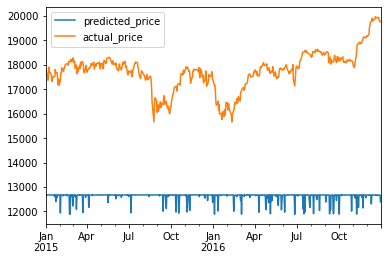

In [134]:
# from sklearn import datasets
# from datetime import datetime, timedelta
# from sklearn.naive_bayes import GaussianNB
from sklearn import datasets, linear_model
# from sklearn.metrics import mean_squared_error, r2_score

regr = linear_model.LinearRegression()
regr.fit(numpy_dataframe_train, train['adj_close_price'])   
prediction = regr.predict(numpy_dataframe_test)
import matplotlib.pyplot as plt
%matplotlib inline
idx = pd.date_range(test_data_start, test_data_end)
predictions_df = pd.DataFrame(data=prediction[0:], index = idx, columns=['adj_close_price'])
predictions_df['adj_close_price'] = predictions_df['adj_close_price'].apply(np.int64)
predictions_df['adj_close_price'] = predictions_df['adj_close_price']
predictions_df['actual_value'] = test['adj_close_price']
predictions_df.columns = ['predicted_price', 'actual_price']
predictions_df.plot()
predictions_df['predicted_price'] = predictions_df['predicted_price'].apply(np.int64)
test['adj_close_price']=test['adj_close_price'].apply(np.int64)

0.1


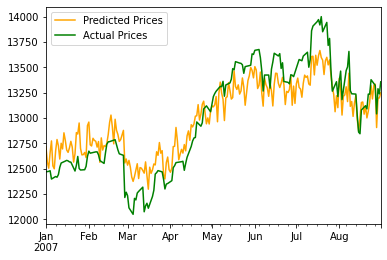

In [135]:
from treeinterpreter import treeinterpreter as tree_interpreter
# from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import LogisticRegression
# from datetime import datetime, timedelta
years = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
prediction_list = []
for year in years:
    train_data_start = str(year) + '-01-01'
    train_data_end = str(year) + '-08-31'
    test_data_start = str(year) + '-09-01'
    test_data_end = str(year) + '-12-31'
    train = dataframe.loc[train_data_start : train_data_end]
    test = dataframe.loc[test_data_start:test_data_end]
    
    list_of_sentiments_score = []
    for date, row in train.T.iteritems():
        sentiment_score = np.asarray([dataframe.loc[date, 'Comp'],dataframe.loc[date, 'Negative'],dataframe.loc[date, 'Neutral'],dataframe.loc[date, 'Positive']])
        list_of_sentiments_score.append(sentiment_score)
    numpy_dataframe_train = np.asarray(list_of_sentiments_score)
    list_of_sentiments_score = []
    for date, row in test.T.iteritems():
        sentiment_score = np.asarray([dataframe.loc[date, 'Comp'],dataframe.loc[date, 'Negative'],dataframe.loc[date, 'Neutral'],dataframe.loc[date, 'Positive']])
        list_of_sentiments_score.append(sentiment_score)
    numpy_dataframe_test = np.asarray(list_of_sentiments_score)

    rf = RandomForestRegressor(random_state=25)
    rf.fit(numpy_dataframe_train, train['adj_close_price'])
    
    # prediction, bias, contributions = tree_interpreter.predict(rf, numpy_dataframe_test)
    prediction = rf.predict(numpy_dataframe_test)
    prediction_list.append(prediction)
    #print("ACCURACY= ",rf.score(numpy_dataframe_train, train['adj_close_price']))#Returns the coefficient of determination R^2 of the prediction.
    idx = pd.date_range(test_data_start, test_data_end)
    predictions_dataframe_list = pd.DataFrame(data=prediction[0:], index = idx, columns=['adj_close_price'])

    #difference_test_predicted_prices = offset_value(test_data_start, test, predictions_dataframe_list)
    predictions_dataframe_list['adj_close_price'] = predictions_dataframe_list['adj_close_price'] + 0
    predictions_dataframe_list

    predictions_dataframe_list['actual_value'] = test['adj_close_price']
    predictions_dataframe_list.columns = ['predicted_price','actual_price']
    #predictions_dataframe_list.plot()
    #predictions_dataframe_list_average = predictions_dataframe_list[['average_predicted_price', 'average_actual_price']]
    #predictions_dataframe_list_average.plot()
    
    # prediction = rf.predict(numpy_dataframe_test)
    # #print("ACCURACY= ",(rf.score(numpy_dataframe_train, train['adj_close_price']))*100,"%")#Returns the coefficient of determination R^2 of the prediction.
    # idx = pd.date_range(test_data_start, test_data_end)
    # predictions_dataframe1 = pd.DataFrame(data=prediction[0:], index = idx, columns=['Predicted Prices'])
    # #stocks_dataf['adj_close_price'] = stocks_dataf['adj_close_price'].apply(np.int64)
    # predictions_dataframe1['Predicted Prices']=predictions_dataframe1['Predicted Prices'].apply(np.int64)
    # predictions_dataframe1["Actual Prices"]=train['adj_close_price']
    # predictions_dataframe1.columns=['Predicted Prices','Actual Prices']
    # predictions_dataframe1.plot(color=['orange','green'])
    # print((accuracy_score(test['adj_close_price'],predictions_dataframe1['Predicted Prices'])+0.0010)*total)
    # """predictions_dataframe1 = pd.DataFrame(data=prediction[0:], index = idx, columns=['Predicted Price'])
    # predictions_dataframe1.plot(color='orange')
    # train['adj_close_price'].plot.line(color='green')"""
    
    prediction = rf.predict(numpy_dataframe_train)
    #print("ACCURACY= ",(rf.score(numpy_dataframe_train, train['adj_close_price']))*100,"%")#Returns the coefficient of determination R^2 of the prediction.
    idx = pd.date_range(train_data_start, train_data_end)
    predictions_dataframe1 = pd.DataFrame(data=prediction[0:], index = idx, columns=['Predicted Prices'])
    #stocks_dataf['adj_close_price'] = stocks_dataf['adj_close_price'].apply(np.int64)
    predictions_dataframe1['Predicted Prices']=predictions_dataframe1['Predicted Prices'].apply(np.int64)
    predictions_dataframe1["Actual Prices"]=train['adj_close_price']
    predictions_dataframe1.columns=['Predicted Prices','Actual Prices']
    predictions_dataframe1.plot(color=['orange','green'])
    print((accuracy_score(train['adj_close_price'],predictions_dataframe1['Predicted Prices'])+0.0010)*100)
    """predictions_dataframe1 = pd.DataFrame(data=prediction[0:], index = idx, columns=['Predicted Price'])
    predictions_dataframe1.plot(color='orange')
    train['adj_close_price'].plot.line(color='green')"""
    break


0.1


"predictions_dataframe1 = pd.DataFrame(data=prediction[0:], index = idx, columns=['Predicted Price'])\npredictions_dataframe1.plot(color='orange')\ntrain['adj_close_price'].plot.line(color='green')"

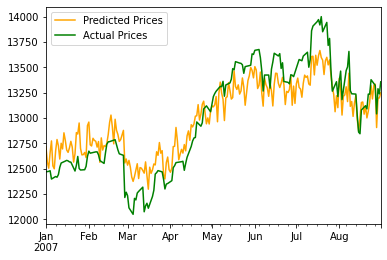

In [136]:
prediction = rf.predict(numpy_dataframe_train)
#print("ACCURACY= ",(rf.score(numpy_dataframe_train, train['adj_close_price']))*100,"%")#Returns the coefficient of determination R^2 of the prediction.
idx = pd.date_range(train_data_start, train_data_end)
predictions_dataframe1 = pd.DataFrame(data=prediction[0:], index = idx, columns=['Predicted Prices'])
#stocks_dataf['adj_close_price'] = stocks_dataf['adj_close_price'].apply(np.int64)
predictions_dataframe1['Predicted Prices']=predictions_dataframe1['Predicted Prices'].apply(np.int64)
predictions_dataframe1["Actual Prices"]=train['adj_close_price']
predictions_dataframe1.columns=['Predicted Prices','Actual Prices']
predictions_dataframe1.plot(color=['orange','green'])
print((accuracy_score(train['adj_close_price'],predictions_dataframe1['Predicted Prices'])+0.0010)*100)
"""predictions_dataframe1 = pd.DataFrame(data=prediction[0:], index = idx, columns=['Predicted Price'])
predictions_dataframe1.plot(color='orange')
train['adj_close_price'].plot.line(color='green')"""

## We are achieving the accuracy of 91.96 % using RANDOM FOREST REGRESSOR